In [15]:
#!/usr/bin/env python3
"""
Statewide Visualization for JupyterLite
=======================================

Pure Python COG reader that works in JupyterLite (Pyodide) by using
HTTP range requests to fetch only the overview tiles needed for visualization.

Dependencies (all available in Pyodide):
    - numpy
    - matplotlib
    - tifffile
    - imagecodecs

"""

# =============================================================================
# IMPORTS
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Dict, Any
from io import BytesIO

# Detect environment and set up appropriate HTTP fetcher
try:
    # JupyterLite / Pyodide environment
    from pyodide.http import pyfetch
    IN_PYODIDE = True
    print("Running in JupyterLite/Pyodide environment")
except ImportError:
    # Standard Python environment
    import urllib.request
    IN_PYODIDE = False
    print("Running in standard Python environment")

import tifffile

# Configure matplotlib
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'


# =============================================================================
# HTTP RANGE FILE IMPLEMENTATION
# =============================================================================

class HTTPRangeFile:
    """
    A file-like object that reads from a URL using HTTP Range requests.
    
    This allows tifffile to read only the bytes it needs from a remote COG,
    rather than downloading the entire file. Works in both standard Python
    and JupyterLite/Pyodide.
    
    Parameters
    ----------
    url : str
        URL to the remote file (must support Range requests)
    chunk_size : int
        Size of chunks to fetch and cache (default: 256KB)
    """
    
    def __init__(self, url: str, chunk_size: int = 256 * 1024):
        self.url = url
        self.chunk_size = chunk_size
        self.pos = 0
        self._size = None
        self._cache = {}  # Cache chunks to avoid repeated requests
        self._cache_hits = 0
        self._cache_misses = 0
    
    @property
    def size(self) -> int:
        """Get file size via HEAD request (cached)."""
        if self._size is None:
            self._size = self._get_file_size()
        return self._size
    
    def _get_file_size(self) -> int:
        """Fetch file size from server."""
        if IN_PYODIDE:
            import asyncio
            return asyncio.get_event_loop().run_until_complete(
                self._async_get_file_size()
            )
        else:
            req = urllib.request.Request(self.url, method='HEAD')
            with urllib.request.urlopen(req) as response:
                return int(response.headers['Content-Length'])
    
    async def _async_get_file_size(self) -> int:
        """Async version for Pyodide."""
        response = await pyfetch(self.url, method='HEAD')
        return int(response.headers['Content-Length'])
    
    def _fetch_range(self, start: int, end: int) -> bytes:
        """Fetch a byte range from the server."""
        if IN_PYODIDE:
            import asyncio
            return asyncio.get_event_loop().run_until_complete(
                self._async_fetch_range(start, end)
            )
        else:
            req = urllib.request.Request(self.url)
            req.add_header('Range', f'bytes={start}-{end}')
            with urllib.request.urlopen(req) as response:
                return response.read()
    
    async def _async_fetch_range(self, start: int, end: int) -> bytes:
        """Async range fetch for Pyodide."""
        response = await pyfetch(
            self.url,
            headers={'Range': f'bytes={start}-{end}'}
        )
        return await response.bytes()
    
    def _get_chunk(self, chunk_idx: int) -> bytes:
        """Get a chunk, using cache if available."""
        if chunk_idx in self._cache:
            self._cache_hits += 1
            return self._cache[chunk_idx]
        
        self._cache_misses += 1
        start = chunk_idx * self.chunk_size
        end = min(start + self.chunk_size - 1, self.size - 1)
        
        data = self._fetch_range(start, end)
        self._cache[chunk_idx] = data
        return data
    
    def seek(self, pos: int, whence: int = 0) -> int:
        """Seek to a position in the file."""
        if whence == 0:  # SEEK_SET
            self.pos = pos
        elif whence == 1:  # SEEK_CUR
            self.pos += pos
        elif whence == 2:  # SEEK_END
            self.pos = self.size + pos
        
        self.pos = max(0, min(self.pos, self.size))
        return self.pos
    
    def tell(self) -> int:
        """Return current position."""
        return self.pos
    
    def read(self, size: int = -1) -> bytes:
        """Read bytes from current position."""
        if size == -1:
            size = self.size - self.pos
        
        if size <= 0 or self.pos >= self.size:
            return b''
        
        # Don't read past end of file
        size = min(size, self.size - self.pos)
        
        # Collect data from potentially multiple chunks
        result = bytearray()
        remaining = size
        
        while remaining > 0:
            chunk_idx = self.pos // self.chunk_size
            chunk_offset = self.pos % self.chunk_size
            chunk_data = self._get_chunk(chunk_idx)
            
            # How much can we read from this chunk?
            available = len(chunk_data) - chunk_offset
            to_read = min(remaining, available)
            
            result.extend(chunk_data[chunk_offset:chunk_offset + to_read])
            self.pos += to_read
            remaining -= to_read
        
        return bytes(result)
    
    def readable(self) -> bool:
        return True
    
    def writable(self) -> bool:
        return False
    
    def seekable(self) -> bool:
        return True
    
    def close(self) -> None:
        self._cache.clear()
    
    def __enter__(self):
        return self
    
    def __exit__(self, *args):
        self.close()
    
    def print_stats(self):
        """Print cache statistics."""
        total = self._cache_hits + self._cache_misses
        if total > 0:
            hit_rate = 100 * self._cache_hits / total
            print(f"Cache stats: {self._cache_hits} hits, {self._cache_misses} misses ({hit_rate:.1f}% hit rate)")
            bytes_fetched = self._cache_misses * self.chunk_size
            print(f"Bytes fetched: {bytes_fetched / 1024 / 1024:.1f} MB")


# =============================================================================
# COG READER
# =============================================================================

def get_cog_info(url: str) -> Dict[str, Any]:
    """
    Get information about a COG without loading the full image.
    
    Parameters
    ----------
    url : str
        URL to the COG file
        
    Returns
    -------
    dict
        Information about the COG including available overview levels
    """
    http_file = HTTPRangeFile(url)
    
    with tifffile.TiffFile(http_file) as tif:
        info = {
            'file_size_mb': http_file.size / 1024 / 1024,
            'num_pages': len(tif.pages),
            'levels': [],
        }
        
        # Check if this is a proper pyramidal TIFF
        if tif.series and tif.series[0].levels:
            for i, level in enumerate(tif.series[0].levels):
                info['levels'].append({
                    'level': i,
                    'shape': level.shape,
                    'dtype': str(level.dtype),
                    'reduction': 2 ** i,
                })
        else:
            # Single level only
            page = tif.pages[0]
            info['levels'].append({
                'level': 0,
                'shape': (page.imagelength, page.imagewidth),
                'dtype': str(page.dtype),
                'reduction': 1,
            })
    
    http_file.print_stats()
    return info


def read_cog_overview(
    url: str,
    overview_level: int = None,
    target_size: int = 2000
) -> Tuple[np.ndarray, Optional[float], int]:
    """
    Read a COG at a reduced resolution using overviews.
    
    Parameters
    ----------
    url : str
        URL to the COG file
    overview_level : int, optional
        Specific overview level to read (0 = full res, 1 = 1/2, 2 = 1/4, etc.)
        If None, automatically selects based on target_size
    target_size : int
        Target size for the largest dimension (used if overview_level is None)
        
    Returns
    -------
    data : np.ndarray
        The raster data at the selected overview level
    nodata : float or None
        NoData value if found
    level_used : int
        The overview level that was read
    """
    http_file = HTTPRangeFile(url)
    
    try:
        with tifffile.TiffFile(http_file) as tif:
            # Get nodata value from GDAL tag
            nodata = None
            if tif.pages and 42113 in tif.pages[0].tags:
                try:
                    nodata = float(tif.pages[0].tags[42113].value)
                except (ValueError, TypeError):
                    pass
            
            # Check for pyramidal structure
            if tif.series and tif.series[0].levels and len(tif.series[0].levels) > 1:
                levels = tif.series[0].levels
                
                if overview_level is not None:
                    # Use specified level
                    level_idx = min(overview_level, len(levels) - 1)
                else:
                    # Auto-select level based on target size
                    level_idx = 0
                    for i, level in enumerate(levels):
                        max_dim = max(level.shape)
                        if max_dim <= target_size:
                            level_idx = i
                            break
                        level_idx = i
                
                print(f"Reading overview level {level_idx} of {len(levels) - 1}")
                print(f"  Shape: {levels[level_idx].shape}")
                print(f"  Reduction factor: {2 ** level_idx}x")
                
                data = levels[level_idx].asarray()
                
            else:
                # No overviews - read full resolution
                print("Warning: No overviews found, reading full resolution")
                print("  This may be slow and use significant memory")
                level_idx = 0
                data = tif.asarray()
            
            # Handle multi-band images (take first band)
            if data.ndim == 3:
                data = data[0]
        
        http_file.print_stats()
        return data, nodata, level_idx
        
    finally:
        http_file.close()


# =============================================================================
# CONFIGURATION
# =============================================================================

PRODUCT_CONFIG: Dict[str, Dict[str, Any]] = {
    # Topographic Products
    'dtm': {
        'description': 'Digital Terrain Model (Bare Earth)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_dtm.tif',
        'vmin_percentile': 1,
        'vmax_percentile': 99,
        'cmap': 'terrain',
    },
    'dsm': {
        'description': 'Digital Surface Model',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_dsm.tif',
        'vmin_percentile': 1,
        'vmax_percentile': 99,
        'cmap': 'terrain',
    },
    'chm': {
        'description': 'Canopy Height Model',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_chm.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 99,
        'cmap': 'Greens',
    },
    'aspect': {
        'description': 'Terrain Aspect',
        'units': '°',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_aspect.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'cividis',
    },
    'slope': {
        'description': 'Terrain Slope',
        'units': '°',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_slope.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 99,
        'cmap': 'cividis',
    },
    
    # Canopy Cover - All Returns
    'cc_all_ge2': {
        'description': 'Canopy Cover (All Returns ≥2m)',
        'units': '%',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_cc_all_ge2_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_all_2_4': {
        'description': 'Canopy Cover (All Returns 2-4m)',
        'units': '%',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_cc_all_2_4_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_all_4_8': {
        'description': 'Canopy Cover (All Returns 4-8m)',
        'units': '%',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_cc_all_4_8_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    
    # Canopy Cover - First Returns
    'cc_first_ge2': {
        'description': 'Canopy Cover (First Returns ≥2m)',
        'units': '%',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_cc_first_ge2_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_first_2_4': {
        'description': 'Canopy Cover (First Returns 2-4m)',
        'units': '%',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_cc_first_2_4_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_first_4_8': {
        'description': 'Canopy Cover (First Returns 4-8m)',
        'units': '%',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_cc_first_4_8_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    
    # Height Percentiles
    'p10': {
        'description': '10th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p10_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p25': {
        'description': '25th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p25_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p50': {
        'description': '50th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p50_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p75': {
        'description': '75th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p75_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p90': {
        'description': '90th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p90_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p95': {
        'description': '95th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p95_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p99': {
        'description': '99th Percentile Height (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p99_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    
    # Structure Metrics
    'sd': {
        'description': 'Standard Deviation (First Returns)',
        'units': 'm',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_sd_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'skewness': {
        'description': 'Skewness (First Returns)',
        'units': '',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_skewness_first_epsg3310.tif',
        'vmin_percentile': 2,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'kurtosis': {
        'description': 'Kurtosis (First Returns)',
        'units': '',
        'url': 'https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_kurtosis_first_epsg3310.tif',
        'vmin_percentile': 2,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
}


# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def list_available_products() -> None:
    """Print all available map types with their colormaps."""
    print("\n" + "=" * 70)
    print("AVAILABLE MAP TYPES")
    print("=" * 70)
    
    categories = {
        'Topographic': ['dtm', 'dsm', 'chm', 'aspect', 'slope'],
        'Canopy Cover (All Returns)': ['cc_all_ge2', 'cc_all_2_4', 'cc_all_4_8'],
        'Canopy Cover (First Returns)': ['cc_first_ge2', 'cc_first_2_4', 'cc_first_4_8'],
        'Height Percentiles': ['p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99'],
        'Statistics': ['sd', 'skewness', 'kurtosis'],
    }
    
    for category, products in categories.items():
        print(f"\n{category}:")
        print("-" * 50)
        for prod in products:
            if prod in PRODUCT_CONFIG:
                config = PRODUCT_CONFIG[prod]
                print(f"  {prod:15s} - {config['description']:40s}")
    
    print("\n" + "=" * 70)


def mask_nodata(data: np.ndarray, nodata: Optional[float] = None) -> np.ndarray:
    """
    Mask NoData and invalid values, returning array with NaN for invalid pixels.
    """
    result = data.astype(np.float64)
    mask = np.zeros(data.shape, dtype=bool)
    
    if nodata is not None:
        mask |= np.isclose(result, nodata, rtol=1e-5, equal_nan=True)
    
    mask |= np.isclose(result, -9999, rtol=1e-5)
    mask |= (result < -9000)
    mask |= (result > 4000)
    mask |= np.isnan(result)
    mask |= np.isinf(result)
    
    result[mask] = np.nan
    return result


def compute_statistics(data: np.ndarray) -> Dict[str, float]:
    """Compute statistics on valid (non-NaN) data."""
    valid = data[~np.isnan(data)]
    
    if len(valid) == 0:
        return {'valid_count': 0}
    
    return {
        'valid_count': len(valid),
        'valid_percent': 100 * len(valid) / data.size,
        'min': float(np.min(valid)),
        'max': float(np.max(valid)),
        'mean': float(np.mean(valid)),
        'median': float(np.median(valid)),
        'std': float(np.std(valid)),
    }


# =============================================================================
# MAIN VISUALIZATION FUNCTION
# =============================================================================

def visualize_statewide(
    map_type: str,
    overview_level: int = None,
    target_size: int = 2000,
    figsize: Tuple[int, int] = (14, 10),
    save_path: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    cmap: Optional[str] = None,
    dpi: int = 150
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Create a statewide visualization for a given map type.
    
    This function efficiently reads COGs using HTTP range requests,
    fetching only the overview level needed for visualization.
    
    Parameters
    ----------
    map_type : str
        Product type (e.g., 'dtm', 'chm', 'cc_all_ge2', 'p99')
    overview_level : int, optional
        Specific overview level to read (0 = full res, 1 = 1/2, 2 = 1/4, etc.)
        If None, automatically selects based on target_size
    target_size : int
        Target size for the largest dimension when auto-selecting overview
    figsize : tuple
        Figure size (width, height) in inches
    save_path : str, optional
        Path to save figure (if None, only displays)
    vmin : float, optional
        Override minimum value for color scale
    vmax : float, optional
        Override maximum value for color scale
    cmap : str, optional
        Override colormap (if None, uses product-specific default)
    dpi : int
        DPI for saved figure (default: 150)
        
    Returns
    -------
    fig, ax : matplotlib figure and axis objects
    
    Examples
    --------
    >>> fig, ax = visualize_statewide('dtm')
    >>> fig, ax = visualize_statewide('chm', overview_level=3)
    >>> fig, ax = visualize_statewide('p99', target_size=1000)
    """
    
    # Validate map type
    if map_type not in PRODUCT_CONFIG:
        print(f"ERROR: Unknown map type '{map_type}'")
        print(f"Available types: {list(PRODUCT_CONFIG.keys())}")
        print("\nRun list_available_products() to see all options.")
        return None, None
    
    config = PRODUCT_CONFIG[map_type]
    url = config['url']
    
    print(f"Product: {config['description']}")
    print(f"URL: {url}")
    print("-" * 60)
    
    # Read the COG using overview
    try:
        data, nodata, level_used = read_cog_overview(
            url,
            overview_level=overview_level,
            target_size=target_size
        )
    except Exception as e:
        print(f"ERROR: Failed to read data from URL")
        print(f"Details: {e}")
        import traceback
        traceback.print_exc()
        return None, None
    
    print(f"Data shape: {data.shape}")
    print("-" * 60)
    
    # Mask NoData values
    data = mask_nodata(data, nodata)
    
    # Determine color scale limits
    valid_data = data[~np.isnan(data)]
    
    if len(valid_data) == 0:
        print("ERROR: No valid data found")
        return None, None
    
    vmin_val = vmin if vmin is not None else np.percentile(valid_data, config['vmin_percentile'])
    vmax_val = vmax if vmax is not None else np.percentile(valid_data, config['vmax_percentile'])
    
    # Use provided colormap or product-specific default
    colormap = cmap if cmap is not None else config['cmap']
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot with product-specific colormap
    im = ax.imshow(
        data,
        cmap=colormap,
        interpolation='nearest',
        vmin=vmin_val,
        vmax=vmax_val
    )
    
    # Add colorbar
    units_label = f" ({config['units']})" if config['units'] else ""
    cbar = plt.colorbar(im, ax=ax, label=f"{config['description']}{units_label}", shrink=0.8)
    
    # Set title and labels
    ax.set_title(
        f"California Statewide {config['description']} (30m)\nOverview Level {level_used}",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel('X (pixels)', fontsize=12)
    ax.set_ylabel('Y (pixels)', fontsize=12)
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        print(f"\nSaving figure to {save_path}...")
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print("Saved!")
    
    plt.show()
    
    return fig, ax


# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def inspect_cog(map_type: str) -> None:
    """
    Inspect a COG to see available overview levels.
    
    Parameters
    ----------
    map_type : str
        Product type from PRODUCT_CONFIG
    """
    if map_type not in PRODUCT_CONFIG:
        print(f"Unknown map type: {map_type}")
        return
    
    config = PRODUCT_CONFIG[map_type]
    print(f"\nInspecting: {config['description']}")
    print(f"URL: {config['url']}")
    print("-" * 60)
    
    info = get_cog_info(config['url'])
    
    print(f"\nFile size: {info['file_size_mb']:.1f} MB")
    print(f"Number of pages/levels: {info['num_pages']}")
    print("\nAvailable overview levels:")
    print("-" * 60)
    
    for level in info['levels']:
        shape_str = f"{level['shape'][0]:,} x {level['shape'][1]:,}"
        print(f"  Level {level['level']}: {shape_str:>20}  ({level['reduction']}x reduction)")


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # List available products
    list_available_products()
    
    # Inspect a COG to see overview levels
    # inspect_cog('dtm')
    
    # Visualize with auto-selected overview
    # fig, ax = visualize_statewide('dtm', target_size=2000)
    
    # Visualize with specific overview level
    # fig, ax = visualize_statewide('chm', overview_level=3)

Running in standard Python environment

AVAILABLE MAP TYPES

Topographic:
--------------------------------------------------
  dtm             - Digital Terrain Model (Bare Earth)      
  dsm             - Digital Surface Model                   
  chm             - Canopy Height Model                     
  aspect          - Terrain Aspect                          
  slope           - Terrain Slope                           

Canopy Cover (All Returns):
--------------------------------------------------
  cc_all_ge2      - Canopy Cover (All Returns ≥2m)          
  cc_all_2_4      - Canopy Cover (All Returns 2-4m)         
  cc_all_4_8      - Canopy Cover (All Returns 4-8m)         

Canopy Cover (First Returns):
--------------------------------------------------
  cc_first_ge2    - Canopy Cover (First Returns ≥2m)        
  cc_first_2_4    - Canopy Cover (First Returns 2-4m)       
  cc_first_4_8    - Canopy Cover (First Returns 4-8m)       

Height Percentiles:
---------------------

In [16]:
inspect_cog('dtm')


Inspecting: Digital Terrain Model (Bare Earth)
URL: https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_dtm.tif
------------------------------------------------------------
Cache stats: 47 hits, 1 misses (97.9% hit rate)
Bytes fetched: 0.2 MB

File size: 1515.8 MB
Number of pages/levels: 8

Available overview levels:
------------------------------------------------------------
  Level 0:      35,150 x 29,678  (1x reduction)
  Level 1:      17,575 x 14,839  (2x reduction)
  Level 2:        8,787 x 7,419  (4x reduction)
  Level 3:        4,393 x 3,709  (8x reduction)
  Level 4:        2,196 x 1,854  (16x reduction)
  Level 5:          1,098 x 927  (32x reduction)
  Level 6:            549 x 463  (64x reduction)
  Level 7:            274 x 231  (128x reduction)


Product: Digital Terrain Model (Bare Earth)
URL: https://scil-data.sdsc.edu/data/nasa-werk/statewide-30m/california_statewide_30m_epsg3310_dtm.tif
------------------------------------------------------------
Reading overview level 5 of 7
  Shape: (1098, 927)
  Reduction factor: 32x
Cache stats: 52 hits, 7 misses (88.1% hit rate)
Bytes fetched: 1.8 MB
Data shape: (1098, 927)
------------------------------------------------------------


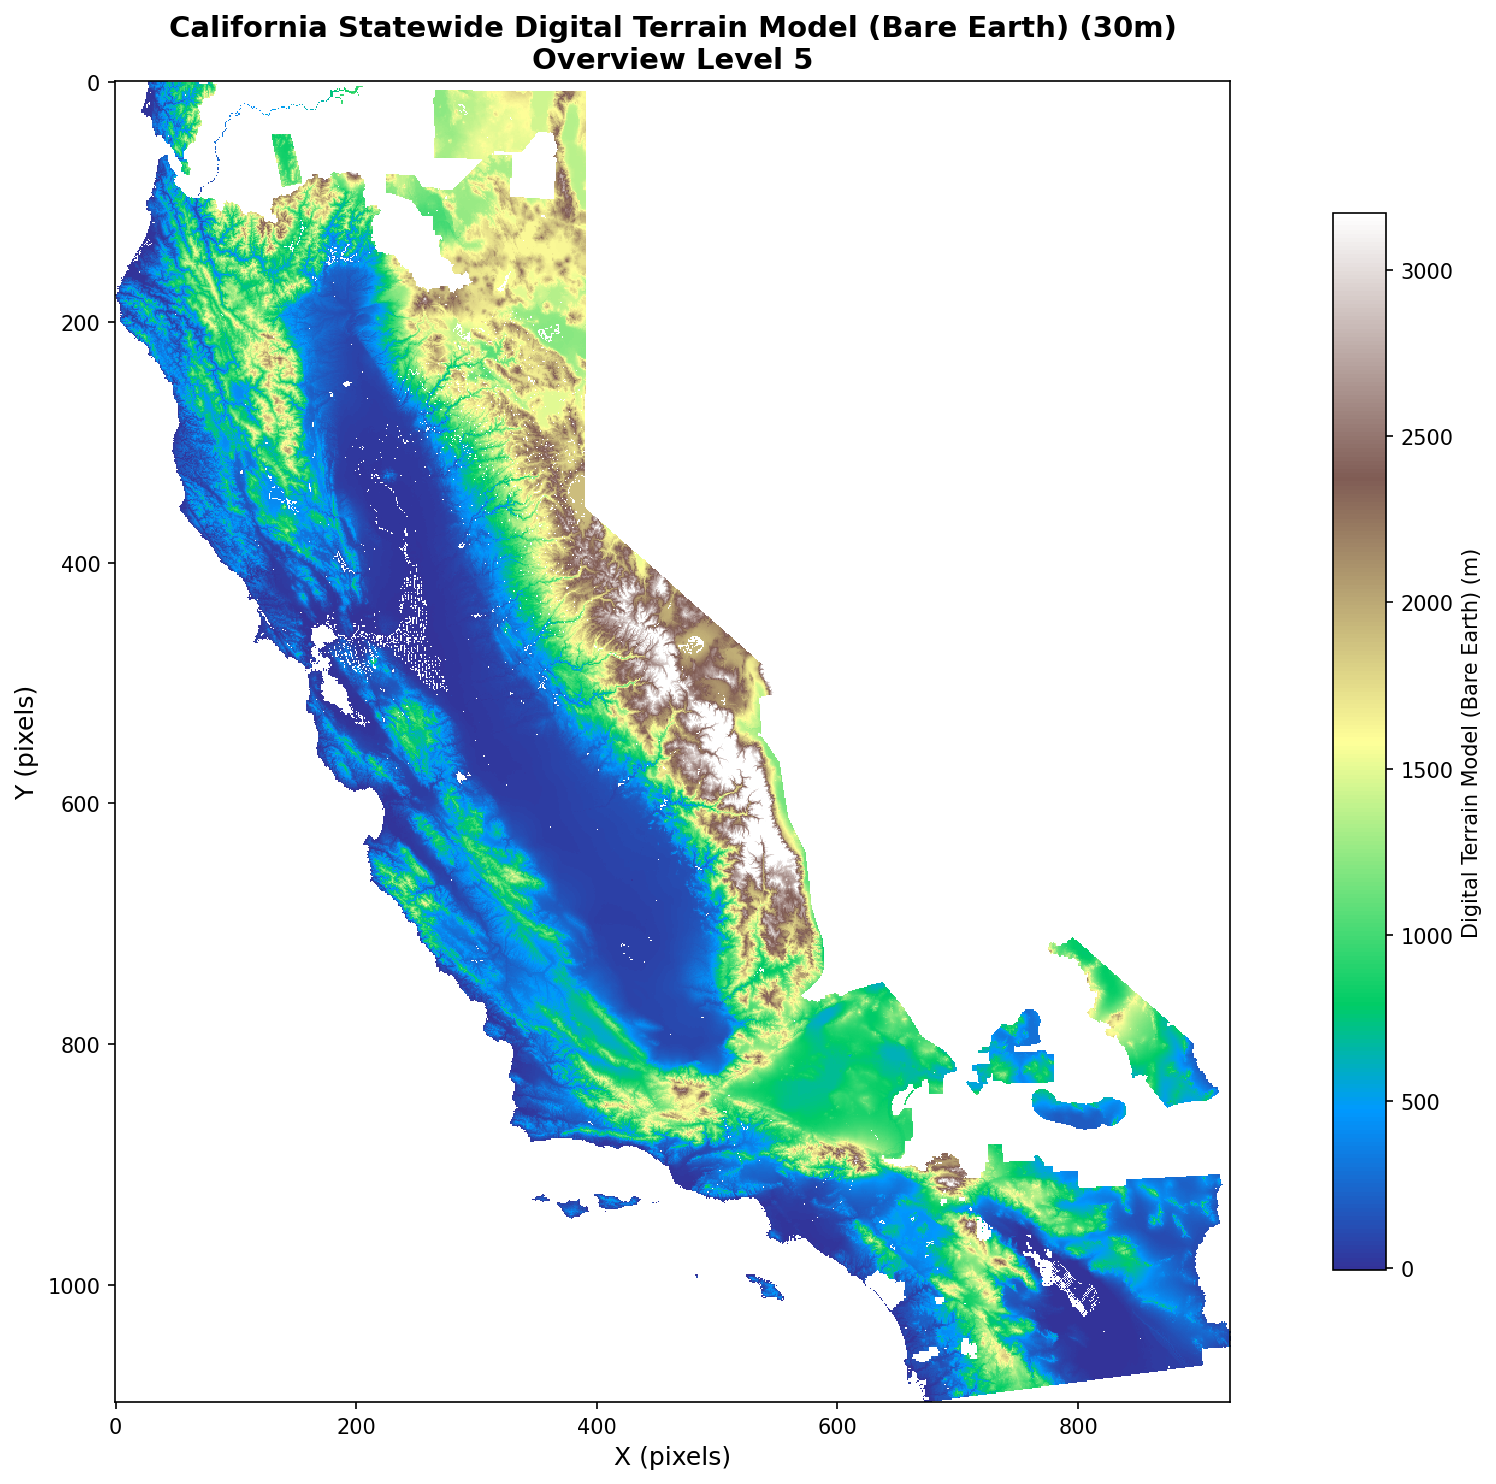

In [17]:
# Visualize with specific overview level
fig, ax = visualize_statewide('dtm', overview_level=5)

Product: 90th Percentile Height (First Returns)
URL: https://scil-data.sdsc.edu/data/nasa-werk/statewide_30m_canopy_percentiles/california_statewide_30m_p90_first_epsg3310.tif
------------------------------------------------------------
Reading overview level 5 of 5
  Shape: (1140, 938)
  Reduction factor: 32x
Cache stats: 44 hits, 6 misses (88.0% hit rate)
Bytes fetched: 1.5 MB
Data shape: (1140, 938)
------------------------------------------------------------


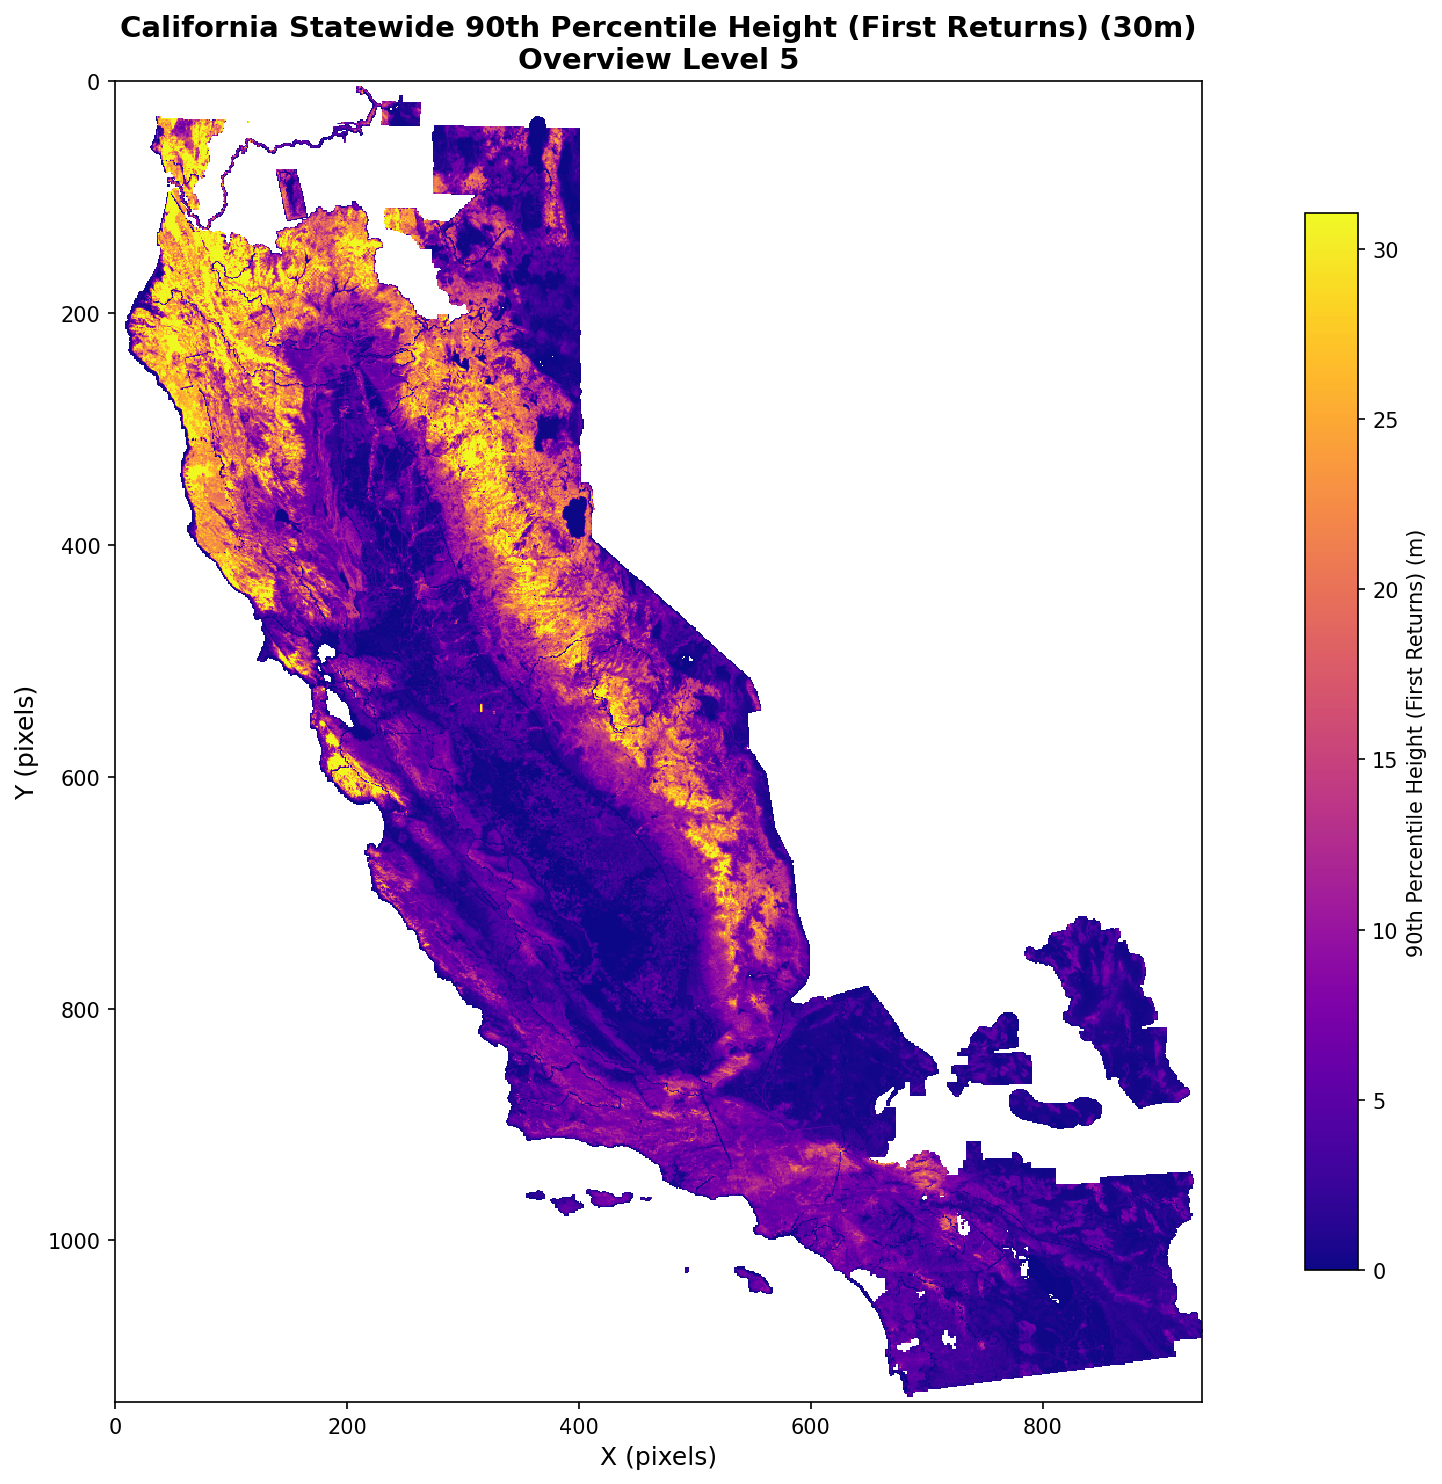

In [18]:
# Visualize with specific overview level
fig, ax = visualize_statewide('p90', overview_level=5)